# 实验数据
这里使用中文科幻小说《三体》为例子，含注释共213章，使用正则表达式构建三体小说数据集，该数据集涵
- chapterid 第几章
- title 章(节)标题
- text 每章节的文本内容(分词后以空格间隔的文本，形态类似英文)

In [1]:
import pandas as pd
import jieba
import re
pd.set_option('display.max_rows', 6)

raw_texts = open('三体.txt', encoding='utf-8').read()
texts = re.split('第\d+章', raw_texts)
texts = [text for text in texts if text]
#中文多了下面一行代码（构造用空格间隔的字符串）
texts = [' '.join(jieba.lcut(text)) for text in texts if text]
titles = re.findall('第\d+章 (.*?)\n', raw_texts)

data = {'chapterid': list(range(1, len(titles)+1)),
        'title': titles,
        'text': texts}
df = pd.DataFrame(data)
df

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/sc/3mnt5tgs419_hk7s16gq61p80000gn/T/jieba.cache
Loading model cost 0.592 seconds.
Prefix dict has been built successfully.


,chapterid,title,text
0,1,科学边界(1),科学 边界 ( 1 ) \n \n 恋上你 看书 网 630book...
1,2,科学边界(2),科学 边界 ( 2 ) \n \n 恋上你 看书 网 630book...
2,3,台球,台球 \n \n 恋上你 看书 网 630bookla ， 最快...
...,...,...,...
210,211,【时间之外，我们的宇宙】(2),【 时间 之外 ， 我们 的 宇宙 】 ( 2 ) \n \n 恋上你 ...
211,212,【时间之外，我们的宇宙】(3),【 时间 之外 ， 我们 的 宇宙 】 ( 3 ) \n \n 恋上你 ...
212,213,注释,注释 \n \n 恋上你 看书 网 630bookla ， 最快...


# tidytextpy库
- get_stopwords 停用词表
- get_sentiments 情感词典
- unnest_tokens 分词函数
- bind_tf_idf  计算tf-idf




# 停用词表
get_stopwords(language)  获取对应语言的停用词表，目前仅支持chinese和english两种语言

In [2]:
from tidytextpy import get_stopwords

cn_stps = get_stopwords('chinese')
#前20个中文的停用词
cn_stps[:20]

['、',
 '。',
 '〈',
 '〉',
 '《',
 '》',
 '一',
 '一些',
 '一何',
 '一切',
 '一则',
 '一方面',
 '一旦',
 '一来',
 '一样',
 '一般',
 '一转眼',
 '七',
 '万一',
 '三']

In [3]:
en_stps = get_stopwords()
#前20个英文文的停用词
en_stps[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers']

# 情感词典
**get_sentiments('词典名')** 调用词典，返回词典的dataframe数据。

- [afinn](http://www2.imm.dtu.dk/pubdb/pubs/6010-full.html) sentiment取值-5到5
- [bing](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html) sentiment取值为positive或negative
- [nrc](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) sentiment取值为positive或negative，及细粒度的情绪分类信息
- [dutir](https://github.com/ZaneMuir/DLUT-Emotionontology) sentiment为中文七种情绪类别（细粒度情绪分类信息）
- hownet sentiment为positive或negative

其中hownet和dutir为**中文情感词典**

In [4]:
from tidytextpy import get_sentiments

#大连理工大学情感本体库，共七种情绪（sentiment）
get_sentiments('dutir')

,sentiment,word
0,惊,冷不防
1,惊,惊动
2,惊,珍闻
...,...,...
27411,惧,匆猝
27412,惧,忧心仲忡
27413,惧,面面厮觑


In [5]:
get_sentiments('nrc')

,word,sentiment
0,abacus,trust
1,abandon,fear
2,abandon,negative
...,...,...
13898,zest,positive
13899,zest,trust
13900,zip,negative


# 分词
``unnest_tokens(__data, output, input)``
- ``__data`` 待处理的dataframe数据
- output 新生成的dataframe中，用于存储分词结果的字段名
- input 待分词数据的字段名(待处理的dataframe数据)


In [16]:
from tidytextpy import unnest_tokens

tokens = unnest_tokens(df, output='word', input='text')
tokens

,chapterid,title,word
0,1,科学边界(1),科学
0,1,科学边界(1),边界
0,1,科学边界(1),1
...,...,...,...
212,213,注释,想到
212,213,注释,暗物质
212,213,注释,。


## 各章节用词量
从这里开始会用到plydata的管道符>> 和相关的常用函数，建议大家遇到不懂的地方查阅plydata文档

In [11]:
from plydata import count, group_by, ungroup


wordfreq = (df 
            >> unnest_tokens(output='word', input='text') #分词
            >> group_by('chapterid')  #按章节分组
            >> count() #对每章用词量进行统计
            >> ungroup() #去除分组
           )

wordfreq

,chapterid,n
0,1,2549
1,2,2666
2,3,1726
...,...,...
210,211,2505
211,212,2646
212,213,2477


## 章节用词量可视化
使用plotnine进行可视化

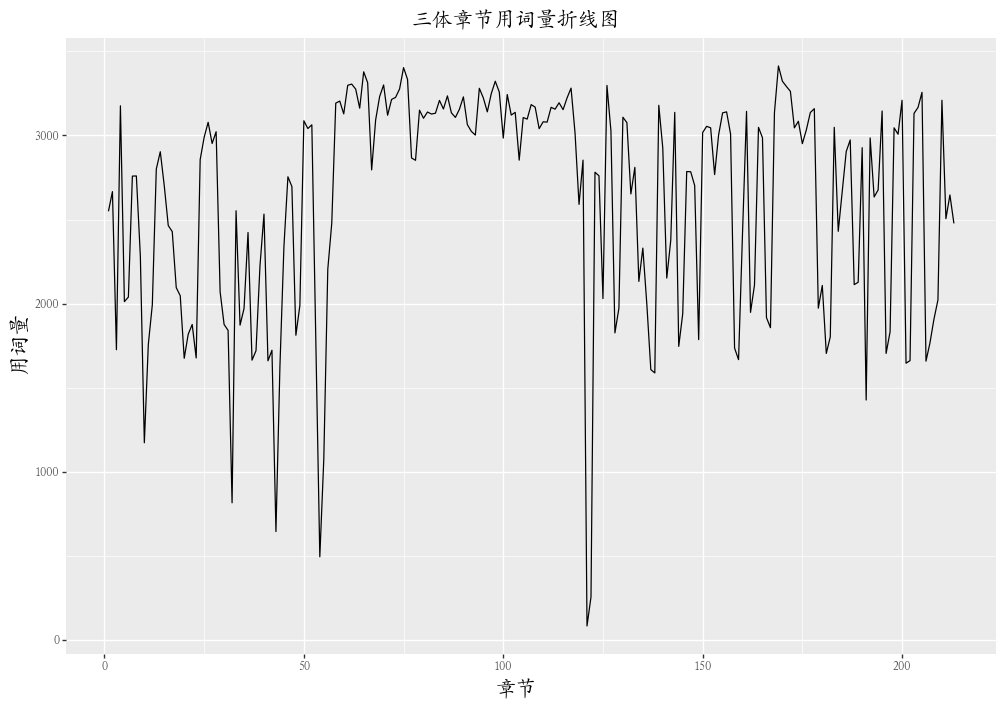

<ggplot: (338899281)>

In [12]:
from plotnine import ggplot, aes, theme, geom_line, labs, theme, element_text
from plotnine.options import figure_size

(ggplot(wordfreq, aes(x='chapterid', y='n'))+
 geom_line()+
 labs(title='三体章节用词量折线图',
      x='章节', 
      y='用词量')+
 theme(figure_size=(12, 8),
       title=element_text(family='Kai', size=15), 
       axis_text_x=element_text(family='Kai'),
       axis_text_y=element_text(family='Kai'))
)

# 情感分析
重要的事情多重复一遍o(*￣︶￣*)o

**get_sentiments('词典名')** 调用词典，返回词典的dataframe数据。

- [afinn](http://www2.imm.dtu.dk/pubdb/pubs/6010-full.html) sentiment取值-5到5
- [bing](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html) sentiment取值为positive或negative
- [nrc](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) sentiment取值为positive或negative，及细粒度的情绪分类信息
- [dutir](https://github.com/ZaneMuir/DLUT-Emotionontology) sentiment为中文七种情绪类别（细粒度情绪分类信息）
- hownet sentiment为positive或negative

其中hownet和dutir为**中文情感词典**


## 情感计算
这里会用到plydata的很多知识点，大家可以查看https://plydata.readthedocs.io/en/latest/index.html 相关函数的文档。

![](img/inner-join.gif)

In [13]:
from plydata import inner_join, count, define, call
from plydata.tidy import spread

chapter_sentiment_score = (
    df #分词
    >> unnest_tokens(output='word', input='text') 
    >> inner_join(get_sentiments('hownet')) #让分词结果与hownet词表交集，给每个词分配sentiment
    >> count('chapterid', 'sentiment')#统计每章中每类sentiment的个数
    >> spread('sentiment', 'n') #将sentiment中的positive和negative转化为两列
    >> call('.fillna', 0) #将缺失值替换为0
    >> define(score = '(positive-negative)/(positive+negative)') #计算每一章的情感分score
)

chapter_sentiment_score

,chapterid,negative,positive,score
0,1,93.0,56.0,-0.248322
1,2,98.0,83.0,-0.082873
2,3,54.0,37.0,-0.186813
...,...,...,...,...
210,211,56.0,73.0,0.131783
211,212,71.0,67.0,-0.028986
212,213,75.0,74.0,-0.006711


## 三体小说情感走势
我记得看完《三体》后，很悲观，觉得人类似乎永远逃不过宇宙的时空规律，心情十分压抑。如果对照小说进行章节的情感分析，应该整体情感分的走势大多在0以下。

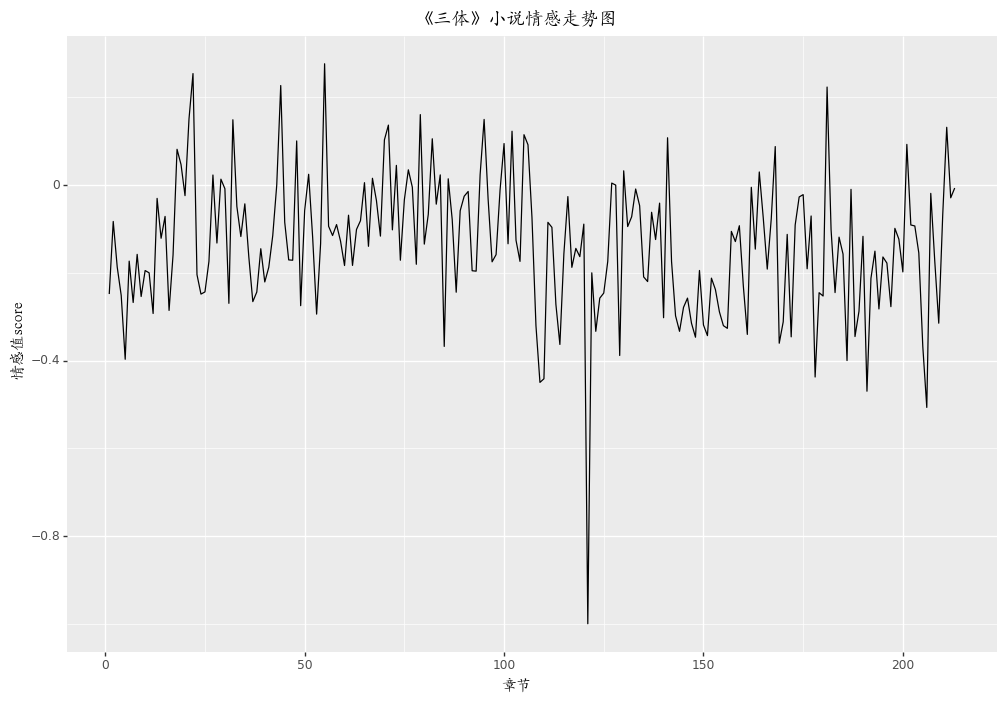

<ggplot: (364239885)>

In [37]:
from plotnine import ggplot, aes, geom_line, element_text, labs, theme

(ggplot(chapter_sentiment_score, aes('chapterid', 'score'))+
 geom_line()+
 labs(x='章节', y='情感值score', title='《三体》小说情感走势图')+
 theme(figure_size=(12, 8),
       title=element_text(family='Kai'))
)

# tf-idf
相比之前的代码，bind_tf_idf运行起来很慢很慢。所以这里用别的数据做实验

## tf-idf实验数据

In [33]:
import pandas as pd
pd.set_option('display.max_rows', 6)

zen = """
The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
"""

zen_split = zen.splitlines()

df = pd.DataFrame({'docid': list(range(len(zen_split))),
                  'text': zen_split})

df

,docid,text
0,0,
1,1,"The Zen of Python, by Tim Peters"
2,2,
...,...,...
19,19,"If the implementation is hard to explain, it's..."
20,20,"If the implementation is easy to explain, it m..."
21,21,Namespaces are one honking great idea -- let's...


## bind_tf_idf
tf表示词频，idf表示词语在文本中的稀缺性，两者的结合体现了一个词的信息量。找出小说中tf-idf最大的词。

``bind_tf_idf(_data, term, document, n)``

- ``_data`` 传入的df
- term df中词语对应的字段名
- document df中文档id的字段名
- n df中词频数对应的字段名

In [36]:
from tidytextpy import bind_tf_idf
from plydata import count, group_by, ungroup

tfidfs = (df
          >> unnest_tokens(output='word', input='text')
          >> count('docid', 'word')
          >> bind_tf_idf(term='word', document='docid', n='n')
         )

tfidfs

,docid,word,n,tf,idf,tf_idf
0,1,the,1,0.142857,1.386294,0.198042
1,1,zen,1,0.142857,2.995732,0.427962
2,1,of,1,0.142857,1.897120,0.271017
...,...,...,...,...,...,...
137,21,more,1,0.090909,2.995732,0.272339
138,21,of,1,0.090909,1.897120,0.172465
139,21,those,1,0.090909,2.995732,0.272339
